In [1]:
import numpy as np
import os

from scipy import ndimage

from numpy import loadtxt
from lmfit.models import GaussianModel,Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture,metrics

from shapely.geometry import Polygon

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

    
from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import ConvexHull
from scipy.spatial import distance
from numpy import linalg 

from skimage import io
from skimage.morphology import medial_axis, skeletonize
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon

from radio_beam.commonbeam import getMinVolEllipse

from grain_utils import grainPreprocess,grainShow,grainMark,grainDraw,grainApprox,grainStats,grainMorphology



In [2]:
grain1_name='Ultra_Co6_2'
grain2_name='Ultra_Co8'
grain3_name='Ultra_Co11'
grain4_name='Ultra_Co15'
grain5_name='Ultra_Co25'
arc_name='arc'

grain1_file_name=grain1_name+'.jpg'
grain2_file_name=grain2_name+'.jpg'
grain3_file_name=grain3_name+'.jpg'
grain4_file_name=grain4_name+'.jpg'
grain5_file_name=grain5_name+'.jpg'
grain6_file_name='Ultra_Co6_2-001.jpg'


grain6_file_name='Ultra_Co11-1.tif'
arc_file_name=arc_name+'.jpg'
path='images'

grain1_pil=Image.open(path+'/'+grain1_file_name)
grain2_pil=Image.open(path+'/'+grain2_file_name)
grain3_pil=Image.open(path+'/'+grain3_file_name)
grain4_pil=Image.open(path+'/'+grain4_file_name)
grain5_pil=Image.open(path+'/'+grain5_file_name)
grain6_pil=Image.open(path+'/'+grain6_file_name)

arc_pil=Image.open(path+'/'+arc_file_name)


h=150

image1=grainPreprocess.image_preprocess(grain1_pil,h=h,k=1)
image2=grainPreprocess.image_preprocess(grain2_pil,h=h,k=1)
image3=grainPreprocess.image_preprocess(grain3_pil,h=h,k=1)
image4=grainPreprocess.image_preprocess(grain4_pil)
image5=grainPreprocess.image_preprocess(grain5_pil,h=h,k=1)
image6=grainPreprocess.image_preprocess(grain6_pil,h=h,k=1)

arc=grainPreprocess.image_preprocess(arc_pil,h=0,k=1)

D:\PROJECTS\python\grain_segmentation\grain_utils.py:58: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img=rgb2gray(gray)
C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:39: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.


In [3]:
def kernel(image,pos):
    x,y=pos
    num=0
    step=1
    for xi in range(x-step,x+step+1):
        for yi in range(y-step,y+step+1):
            if xi<image.shape[0] and yi<image.shape[1]:
                if image[xi,yi]:
                    num+=1
    return num

In [4]:
def del_kernel(image,pos):
    x,y=pos
    step=1
    for xi in range(x-step,x+step+1):
        for yi in range(y-step,y+step+1):
            image[xi,yi]=False
                

In [85]:
def get_tree(image):
    #
    # вовзращает скелеты изображения, где каждый пиксель скелета
    # отображает порядковый номер скелета
    #
    skeleton = np.array(skeletonize(image))
    labels,classes_num=ndimage.label(image)
    
    bones=[[] for i in range(classes_num+1)]
    
    # создает массив индивидуальных скелетов
    # пикселю скелета дается класс, на координатах которого он находится
    # координаты класса определяются ndi.label
    
    for i in range(skeleton.shape[0]):
        for j in range(skeleton.shape[1]):
            if skeleton[i,j]:
                label=labels[i,j]
                bones[label].append((i,j))

    leafs=[[] for i in range(classes_num+1)]
    nodes=[[] for i in range(classes_num+1)]
    temp_image=skeleton.copy()
    # определение узлов и листьев при помощи свертки
    for i,bone in enumerate(bones):
        for pixel in bone:
            val_node=kernel(temp_image,pixel)
            val_leaf=kernel(skeleton,pixel)
            if val_node>3:
                nodes[i].append(pixel)
                del_kernel(temp_image,pixel)
            if val_leaf==2:
                leafs[i].append(pixel)


    return leafs,nodes,classes_num+1

In [131]:
def tree_stats(leafs,nodes):   
    leafs_num=np.full((len(leafs)),2)
    nodes_num=np.zeros((len(nodes)))

    for i,leaf in enumerate(leafs):
        if len(leaf)>1:
            leafs_num[i] = len(leaf)

    for i,node in enumerate(nodes):
            nodes_num[i] = len(node)

    return leafs_num,nodes_num

In [7]:
def tree_dens(array):
    array_copy=array.copy()
    
    array_copy_set=np.sort(np.array(list(set(array_copy))))
    dens_curve=[]
    for arr in array_copy_set:
        num=0
        for ar in array_copy:
            if arr==ar:
                num+=1
        dens_curve.append(num)
    
    dens_curve=np.array(dens_curve)
    return array_copy_set,dens_curve

In [226]:
import cmath

In [239]:
np.log(-2)

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan

In [232]:
image=image5/255
leafs,nodes,classes_num=get_tree(image)
leafs_num,nodes_num=tree_stats(leafs,nodes)

k=nodes_num/leafs_num
x,y=tree_dens(k)
x=x[1:]
y=y[1:]
norm=sum(y)
y=y/norm
y=np.log(y)
x=np.log(x)

y1=cmath.log(y)
x1=cmath.log(x)

leafs_number=sum(leafs_num)
nodes_number=sum(nodes_num)

fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
ax1.imshow(image,cmap='gray')


ax2.plot(x,y)
ax2.scatter(x,y)
name='k=количество узлов/количество листьев'
leafs_text='\nколичество листьев '+str(leafs_number)
nodes_text='\nколичество листьев '+str(int(nodes_number))
text=name+leafs_text+nodes_text

ax2.legend([text],fontsize=15)
ax2.set_ylabel('p(x)',fontsize=15)
ax2.set_xlabel('значение k',fontsize=15)
plt.show()

TypeError: only length-1 arrays can be converted to Python scalars

In [176]:
def apprx_tree(image):
    
    leafs,nodes,classes_num=get_tree(image)
    leafs_num,nodes_num=tree_stats(leafs,nodes)

    x1,y1=tree_dens(leafs_num)
    x2,y2=tree_dens(nodes_num)
    x2=x2[1:]
    y2=y2[1:]

    norm1=sum(y1)
    norm2=sum(y2)

    x1=np.log(x1.reshape((-1,1)))
    y1=np.log(y1.reshape((-1,1))/norm1)
    x2=np.log(x2.reshape((-1,1)))
    y2=np.log(y2.reshape((-1,1))/norm2)

    x_linear1=np.linspace(0.5,x1.max(axis=0),50).reshape(-1, 1)
    x_linear2=np.linspace(0,x2.max(axis=0),50).reshape(-1, 1)
    
    reg1 = LinearRegression().fit(x1,y1)
    reg2 = LinearRegression().fit(x2,y2)

    lin_predict1=reg1.predict(x_linear1)
    lin_predict2=reg2.predict(x_linear2)

    k1=reg1.coef_[0][0]
    k2=reg2.coef_[0][0]

    angle1=round(np.rad2deg(np.arctan(k1)),4)
    angle2=round(np.rad2deg(np.arctan(k2)),4)

    score1=round(reg1.score(x1, y1),2)
    score2=round(reg2.score(x2, y2),2)

    lin_k1='\n угол наклона '+str(angle1)+' градусов'
    acc1='\n точность '+str(score1)
    text1='\nколичество листьев '+str(norm1)+lin_k1+acc1

    lin_k2='\n угол наклона '+str(angle2)+' градусов'
    acc2='\n точность '+str(score2)
    text2='\nколичество узлов '+str(norm2)+lin_k2+acc2


    bins=10
    fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(15,15))

    ax1.imshow(image,cmap='gray')

    ax2.plot(x_linear1,lin_predict1)
    ax2.plot(x_linear2,lin_predict2)
    ax2.scatter(x1,y1)
    ax2.scatter(x2,y2)

    ax2.legend([text1,text2],fontsize=15)
    ax2.set_ylabel('ln(p(x))',fontsize=15)
    ax2.set_xlabel('ln(количество в скелете)',fontsize=15)
    plt.show()



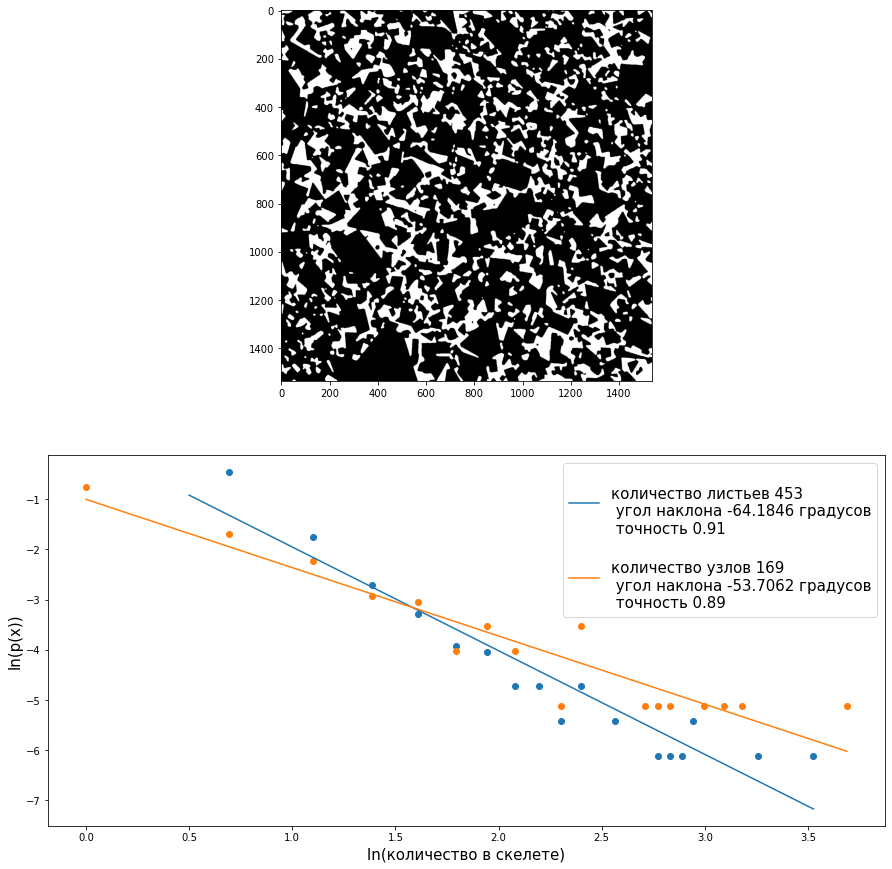

In [180]:
image=image4/255
apprx_tree(image)

In [26]:
def draw_tree(image,leafs,nodes):
    
    skeleton = np.array(skeletonize(image))*255
    im=1-image+skeleton
    im = Image.fromarray(np.uint8(cm.gist_earth(im)*255))
    draw = ImageDraw.Draw(im)

    for j,leaf in enumerate(leafs):
            for i,point in enumerate(leaf):
                x2,y2=point
                r=2

                draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=(0,255,0), width=5)

    for j,node in enumerate(nodes):
            for i,point in enumerate(node):
                x2,y2=point
                r=2

                draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=(0,0,255), width=10)


    return np.array(im)


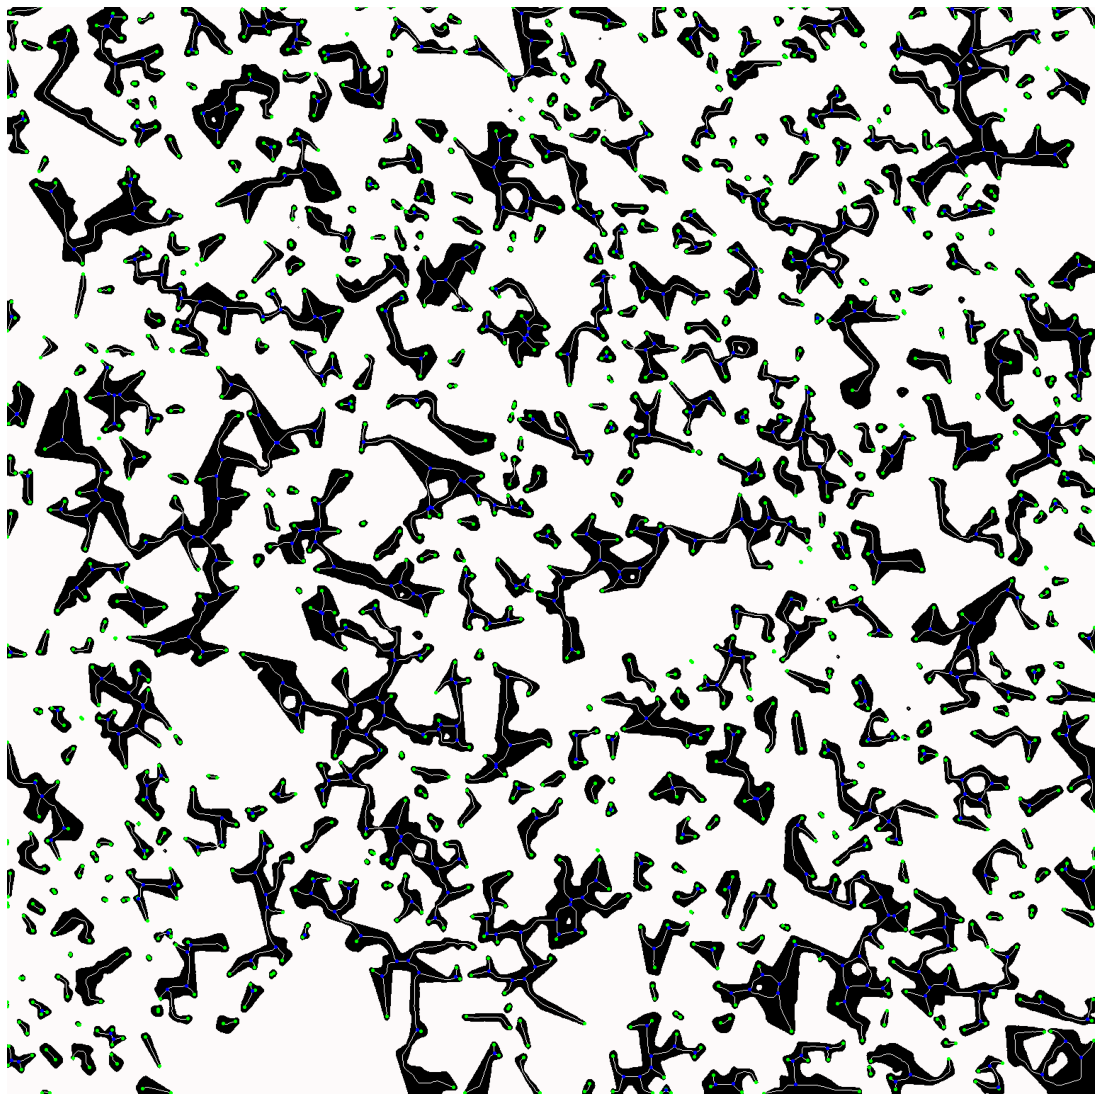

In [27]:
leafs,nodes,classes_num=get_tree(image4/255)
img=draw_tree(image4/255,leafs,nodes)
io.imsave('grain_tree.png',img)
grainShow.img_show(img,cmap='gray')